# Error bar analysis

- In Markov chain Monte Carlo algorithms, the sampled outputs are generally
  correlated.
  
- This has important consequences is the way to quantify the statistical
  error on the results.
  
- We will take a Markov chain from the Ising model and use it to assess different
  strategies to compute error bars.
  
- But before that, let us remember some results for independent variables.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(82373)
plt.style.use('style.mpl')

# Independent random variables

- Imagine we have a set of $N$ *independent* random variables $\{ x_1, x_2, \ldots, x_N \}$
  and they all have the same mean $\mu$ and variance $\sigma^2$.
  
- We introduce the *empirical average*

  \begin{equation*}
    X = \frac{1}{N} \sum_{i=1}^N x_i
  \end{equation*}
  
- Even for finite $N$, we have

  \begin{equation*}
  \langle X \rangle = \frac{1}{N} \sum_{i=1}^N \langle x_i \rangle = \mu
  \end{equation*}
  
- This means that from a finite sample, the *best estimate* for the true average
  value is the sample average.
  
- We say that the sample average is an **unbiased estimator**.

# Standard deviation of the empirical average

- The variance of the empirical average is

  \begin{equation*}
  \sigma_X^2 = \langle X^2 \rangle - \langle X \rangle^2 = \frac{1}{N^2} \sum_{i,j=1}^N \langle x_i x_j
  \rangle  - \frac{1}{N^2} \sum_{i,j=1}^N \langle x_i \rangle \langle x_j \rangle = \frac{\sigma^2}{N}
  \end{equation*}
  
- This is a useful theoretical result, it tells us how the error bar decreases with $N$. But
  we do not know $\sigma$. How do we estimate $\sigma_X^2$ from our data?
  
- It is natural to start from the sample variance

  \begin{equation*}
    s^2 = \frac{1}{N} \sum_{i=1}^N \big( x_i - \frac{1}{N} \sum_{j=1}^N x_j \big)^2
    = \frac{1}{N} \sum_{i=1}^N x_i^2 - \frac{1}{N^2} \sum_{i,j=1}^N x_i x_j
  \end{equation*}
  
- From it's average value, we can design the *best estimate* for the variance of the
  empirical average

  \begin{equation*}
  \langle s^2 \rangle = \langle x_i^2 \rangle - \frac{(N-1)}{N} \langle x_i
  \rangle^2 - \frac{1}{N} \langle x_i^2 \rangle = \frac{N-1}{N} \sigma^2
  \quad \to \quad
  \boxed{
  \sigma_X^2 \simeq \frac{s^2}{N-1}}
  \end{equation*}

# Biased vs unbiased estimators

- In the calculation above, we have an example where the average of an empirical estimator
  (e.g. the sample variance) is not the actual average:
  
  \begin{equation*}
    \sigma^2 = \frac{N}{N-1} \langle s^2 \rangle = \langle s^2 \rangle + \frac{1}{N} \langle s^2 \rangle + \ldots
  \end{equation*}
  
- Such estimators are called **biased estimators**.

- To obtain the best estimate from the sample average, one should add corrections
  starting at order $1/N$.
  
- In general, this happens for non-linear functions $f$ of averages
  
  \begin{equation*}
  f(\langle x \rangle, \langle y \rangle, \ldots) \simeq f(X, Y, \ldots) + \mathcal{O}(\frac{1}{N})
  \end{equation*}
  
  where $f(X,Y,\ldots)$ is the function evaluated at the sample averages $X$, $Y$, ...

- However, in practice, because the standard deviation of the empirical average goes as
  $1/\sqrt{N}$, the corrections to the biased estimators can be neglected.

# An actual Markov chain from the Ising model

- Let us generate a Markov chain for the energy in the Ising model for
  $T = 3$ on an $8 \times 8$ lattice.

In [2]:
def initialize(L):
    σ = np.random.choice([-1,1], size=(L,L))
    return σ

def monte_carlo_step(σ, β):
    
    L = σ.shape[0]
    k, l = np.random.randint(L, size=2) # pick a site   
    ΔE = 2 * σ[k,l] * (σ[(k+1)%L,l] + σ[(k-1)%L,l] + σ[k,(l+1)%L] + σ[k,(l-1)%L])

    # accept the flip
    if np.random.rand() < np.exp(-β * ΔE):
        σ[k,l] *= -1
            
    return σ

def compute_energy(σ):
    L = σ.shape[0]
    E = 0
    for k in range(L):
        for l in range(L):
            E -= σ[k,l] * (σ[(k+1)%L,l] + σ[k,(l+1)%L])
    return E / L**2

In [3]:
# A single Monte Carlo run
n_samples = 2**16
n_warmup = 1000
energies = np.zeros(n_samples)

L = 8
T = 3.0
β = 1 / T
σ = initialize(L)

# MC simulation
for k in range(n_samples + n_warmup):
    monte_carlo_step(σ, β)
    if k >= n_warmup:
        energies[k-n_warmup] = compute_energy(σ)

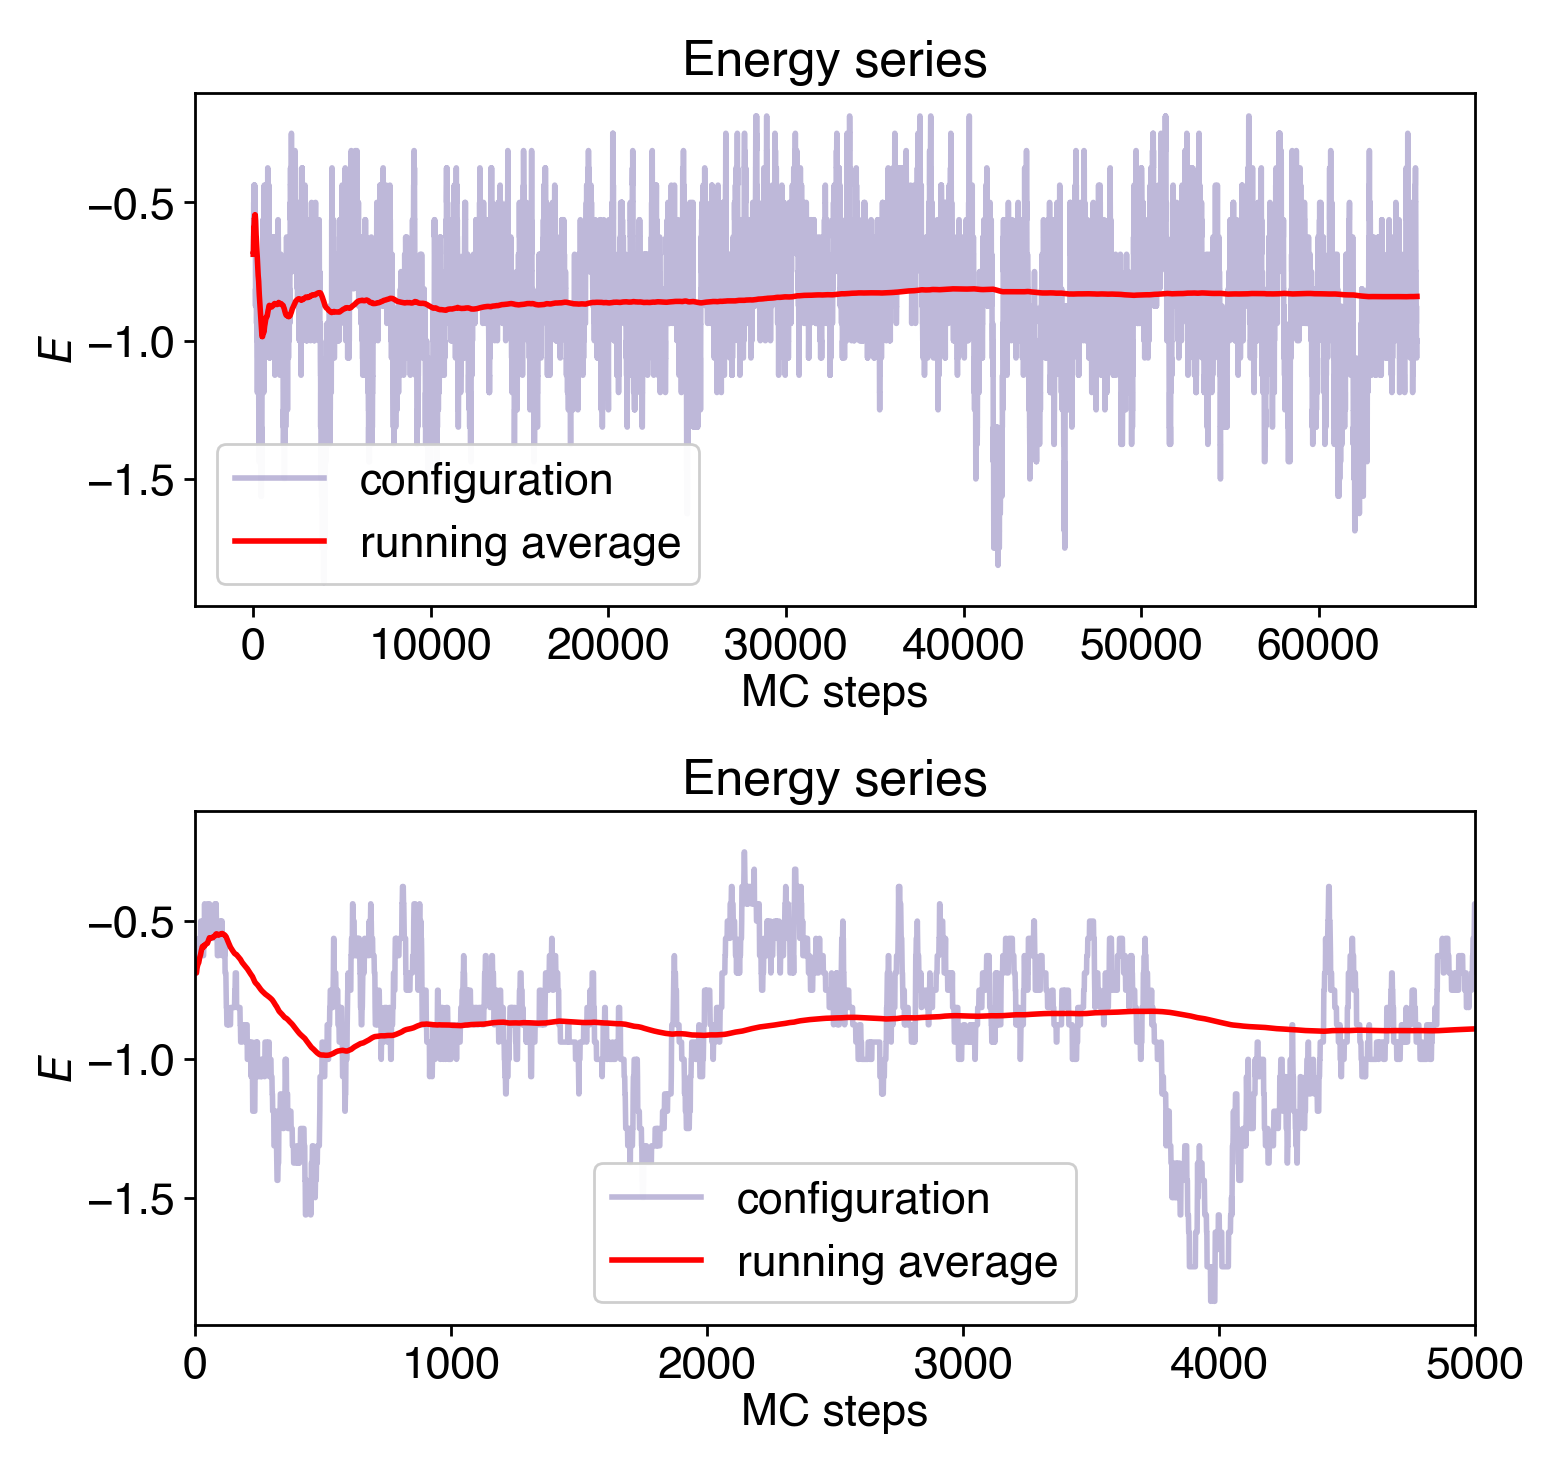

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(8,8))

ax[0].plot(energies, alpha=0.4, label="configuration")
ax[0].plot(np.cumsum(energies) / np.arange(1,n_samples+1), '-r', label="running average")
ax[0].set_title("Energy series")
ax[0].set_xlabel("MC steps")
ax[0].set_ylabel("$E$")
ax[0].legend(frameon=True, framealpha=0.95)

ax[1].plot(energies, alpha=0.4, label="configuration")
ax[1].plot(np.cumsum(energies) / np.arange(1,n_samples+1), '-r', label="running average")
ax[1].set_title("Energy series")
ax[1].set_xlabel("MC steps")
ax[1].set_ylabel("$E$")
ax[1].legend(frameon=True, framealpha=0.95)
ax[1].set_xlim(0, 5000)

plt.subplots_adjust(hspace=0.4)

- By generating several independent Markov chains, we can estimate the actual error bar on
  the empirical average.
  
- This error bar is much larger than the one from the naive formula for independent variables.

- We can infer an *autocorrelation time $\tau$* which gives an idea of how many steps
  are needed for two measurements to be independent

  \begin{equation*}
    2 \tau = \frac{\sigma^2_\mathrm{correct}}{\sigma^2_\mathrm{naive}}
  \end{equation*}

In [5]:
# Let's produce several Markov chains and measure the error bar
n_samples = 2**16
n_warmup = 1000
n_chains = 40

L = 8
T = 3.0
β = 1 / T

energies = np.zeros([n_samples, n_chains])
for i in range(n_chains):
    
    # MC simulation
    σ = initialize(L)
    for k in range(n_samples + n_warmup):
        monte_carlo_step(σ, β)
        if k >= n_warmup:
            energies[k-n_warmup,i] = compute_energy(σ)
            
averages = np.average(energies, axis=0)
print(f"Average energies for {n_chains} Markov chains")
print(averages)

Average energies for 40 Markov chains
[-0.81098747 -0.79907131 -0.78102684 -0.83005905 -0.8475275  -0.84469223
 -0.83393764 -0.8240881  -0.84416676 -0.85199928 -0.84011555 -0.84461021
 -0.83340836 -0.86365891 -0.85155296 -0.845788   -0.83061314 -0.82411575
 -0.83840561 -0.83453465 -0.83289433 -0.84181976 -0.86750793 -0.82081604
 -0.86004066 -0.84789467 -0.82919121 -0.84777069 -0.85413933 -0.81138039
 -0.80091572 -0.8436594  -0.86374569 -0.84765625 -0.84721279 -0.84582615
 -0.8221283  -0.85134506 -0.82412624 -0.84410286]


In [6]:
error_actual = np.std(averages)
print(f"Actual error bar: {error_actual:.5f}")
print(f"Naive calculation: {np.std(energies) / np.sqrt(n_samples-1):.5f}")
print(f"Autocorrlation time τ: {n_samples * np.var(averages)  / np.var(energies) / 2:.0f}")

Actual error bar: 0.01818
Naive calculation: 0.00101
Autocorrlation time τ: 162


# Correlated random variables

- Even for correlated variables, the empirical average is the best estimate of the true average

- An estimate of the variance of the empirical average is obtained from

  \begin{equation*}
    \sigma_X^2 = \frac{s^2}{N-1} \, 2 \tau
  \end{equation*}
  
  where the autocorrelation time $\tau$ is estimated as
  
  \begin{equation*}
    \tau = \frac{1}{2} + \sum_{k=1}^N A(k)
    \qquad
    A(k) = \frac{\langle x_1 x_{1+k} \rangle - \langle x_1 \rangle \langle x_{1+k} \rangle}{s^2}
  \end{equation*}
  
- Drawback: one needs to evaluate the autocorrelation function $A$

In [7]:
# compute autocorrelation function for all chains
auto = np.zeros([n_samples, n_chains])
for i in range(n_chains):
    shifted = energies[:,i] - np.average(energies[:,i])
    auto[:,i] = np.correlate(shifted, shifted, "full")[n_samples-1:]
    auto[:,i] /= auto[0,i]

Actual error bar: 0.01818
Error bar with autocorrelation: 0.01762


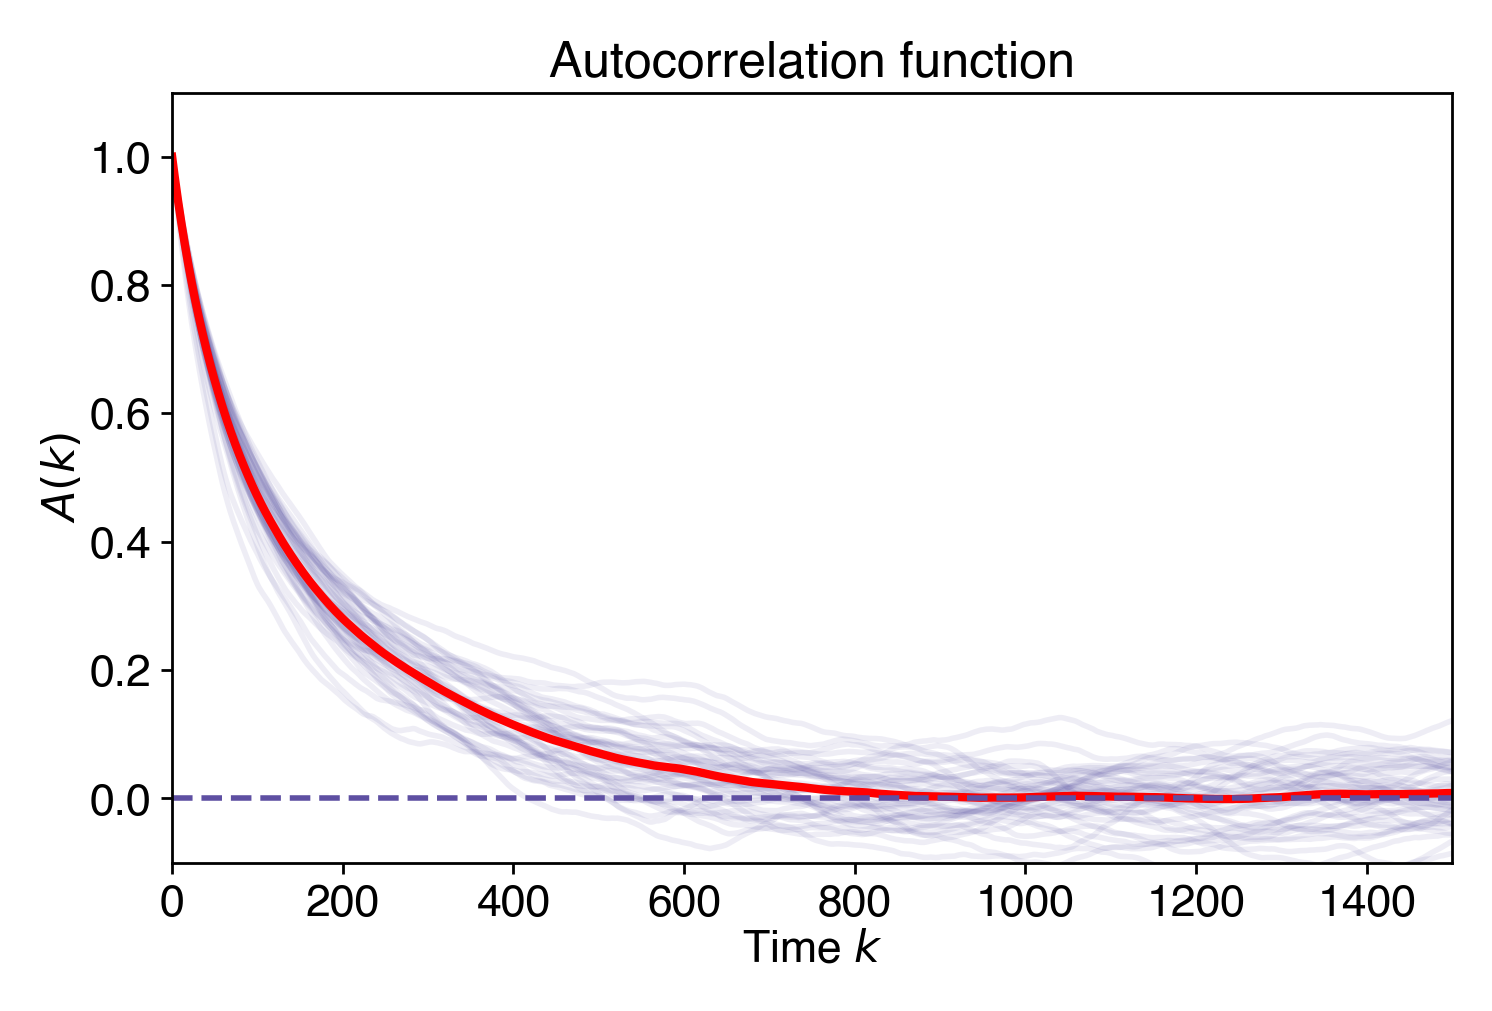

In [8]:
plt.plot(auto, alpha=0.1, c="C1")
plt.plot(np.average(auto, axis=1), 'r-', lw=3)
plt.axhline(0, linestyle="--")
plt.xlim(0, 1500)
plt.ylim(-0.1, 1.1)
plt.title("Autocorrelation function")
plt.xlabel("Time $k$")
plt.ylabel("$A(k)$")

τ = 0.5 + np.sum(np.average(auto, axis=1)[0:1500])
error_auto = np.std(energies[:,0]) * np.sqrt(2 * τ / (n_samples-1))

print(f"Actual error bar: {error_actual:.5f}")
print(f"Error bar with autocorrelation: {error_auto:.5f}")

# Binning analysis

- A versatile approach to estimate error bar is the *binning analysis*.

- The idea is to construct a new series of samples by taking averages of pairs of
  consecutive samples of the original series.
  
  \begin{equation*}
    A^{(\ell)}_i = \frac{1}{2} \left( A^{(\ell-1)}_{2i-1} + A^{(\ell-1)}_{2i} \right)
  \end{equation*}
  
- The new series is twice shorter. We can estimate the variance of this new series.
  and then continue like this.

- If the bins are long enough we can expect that they become independant and that
  we will converge to the correct value.
  
- Only drawback: one may need a very large number of measurements

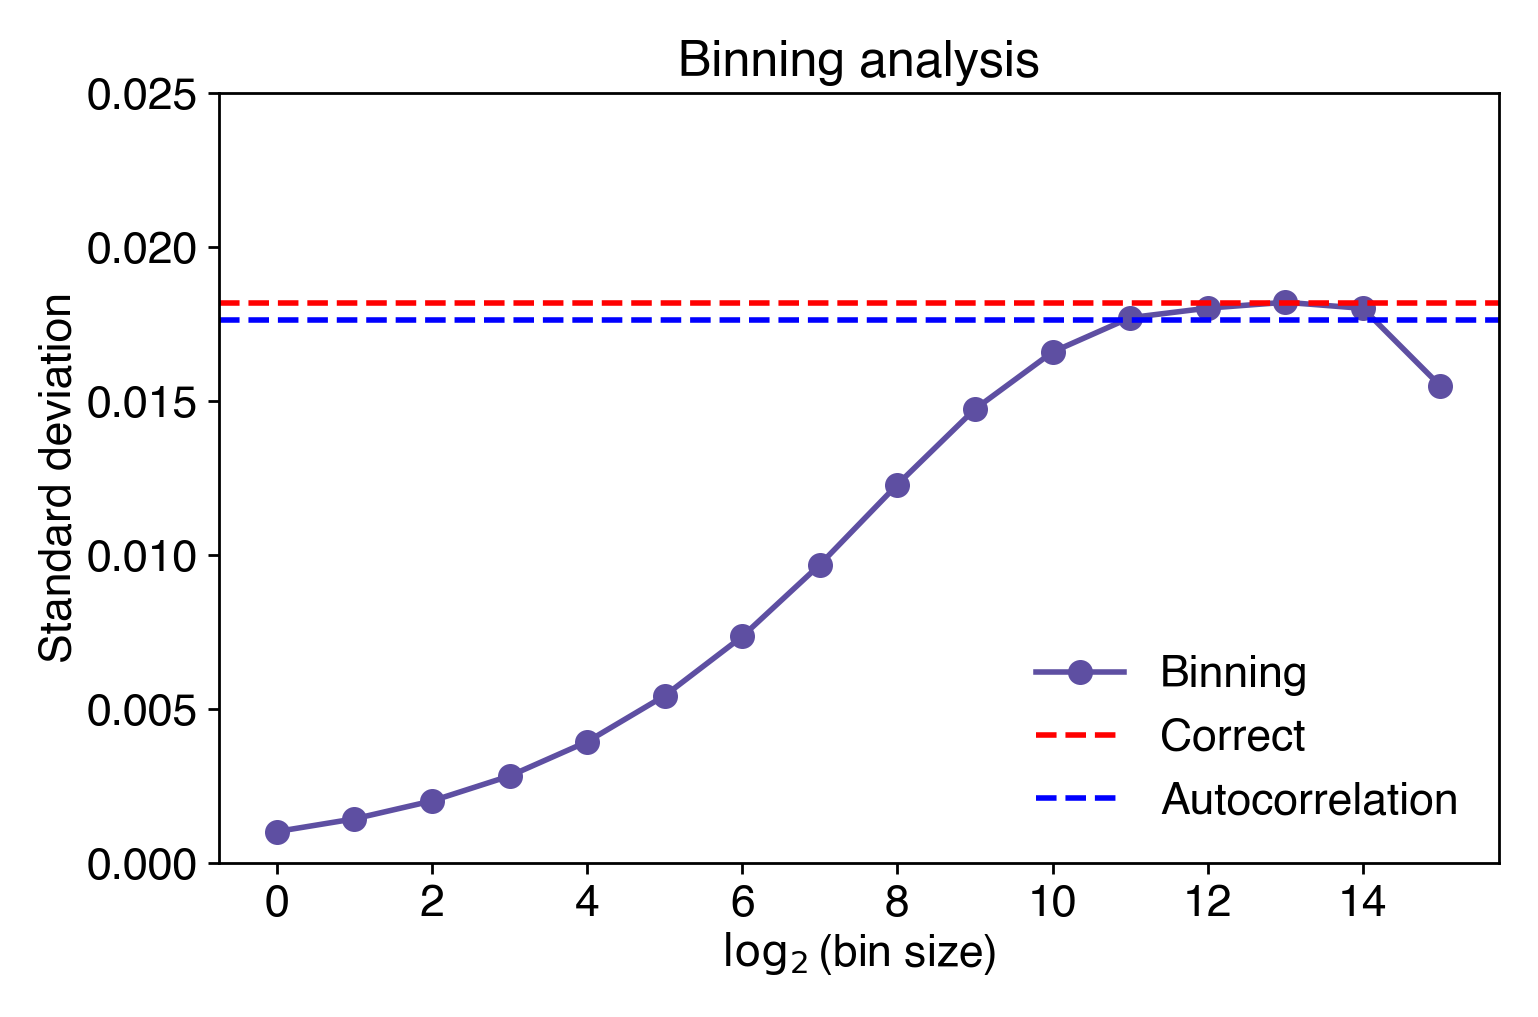

In [9]:
error = np.zeros([16, n_chains])
binned = energies.copy()
for i in range(16):
    error[i,:] = np.std(binned, axis=0) / np.sqrt(binned.shape[0]-1)
    binned = np.average(binned.reshape(-1,2,n_chains), axis=1)
    
#plt.plot(error, alpha=0.1, color='C1');
plt.plot(np.average(error, axis=1), '-o', label="Binning");
plt.axhline(error_actual, color='red', linestyle='--', label="Correct")
plt.axhline(error_auto, color='blue', linestyle='--', label="Autocorrelation")
plt.ylim(0,0.025)
plt.title("Binning analysis")
plt.legend()
plt.xlabel("$\log_2$(bin size)")
plt.ylabel("Standard deviation");

# Error propagation

- We have discussed two ways to obtain the error bar of a sample average.

- How do we estimate the error bar of
  $\mathcal{A} = f(\langle x \rangle, \langle y \rangle)$, a function of averages,
  e.g. the specific heat or Binder cumulant?
  
  \begin{equation*}
    C_V \left(\langle e \rangle, \langle e^2 \rangle \right) = \frac{1}{T^2} \left( \langle e^2 \rangle - \langle e \rangle^2 \right) \qquad
    B_4 \left(\langle m^2 \rangle, \langle m^4 \rangle \right) = \frac{\langle m^4 \rangle}{3\langle m^2 \rangle^2}
  \end{equation*}

- Let's imagine we have produced the sample averages $X$, $Y$. We can estimate 
  $\mathcal{A} \simeq f(X,Y)$. This estimator may be biased, but the correction is in $1/N$
  and can be neglected if $N$ is large.
  
- In order to estimate the error bar, a first possibility is to do the usual *error propagation*
  from the knowledge of the error bar on $X$, $Y$ (obtained e.g. by binning).
  
- This can become cumbersome and is not very generic. A useful and versatile alternative
  approach is the *Jackknife analysis*.

# Jackknife analysis

- Start by cutting the measurement series into $M$ bins.

- For every bin compute the sample averages $X_i$, $Y_i$. Then we introduce
  the Jackknife averages
  
  \begin{equation*}
    X^J_j = \frac{1}{M-1} \sum_{i\ne j} X_j \qquad Y^J_j = \frac{1}{M-1} \sum_{i\ne j} Y_j
    \qquad \mathcal{A}^J_j = f \left( X^J_j, Y^J_j \right)
  \end{equation*}

- We can estimate $\mathcal{A}$ from
  
  \begin{equation*}
    \mathcal{A} \simeq \frac{1}{M} \sum_{i=1}^M \mathcal{A}^J_i = \overline{\mathcal{A}}
  \end{equation*}
  
- The standard deviation for $\mathcal{A}$ is obtained from

  \begin{equation*}
    \sigma_\mathcal{A} \simeq \sqrt{ \frac{M-1}{M}
    \sum_{i=1}^M (\mathcal{A}_i - \overline{\mathcal{A}})^2}
  \end{equation*}
  
- In practice, one typically uses $M \sim 20$.

# Summary

- Some care has to be taken when dealing with correlated data.

- The standard deviation for a sample average can be estimated by

    - Binning analysis
  
    - Computation of the autocorrelation function
  
- Estimators for quantities that are functions of averages are typically
  biased.
  
- The error bar for sample estimates of a quantity $\mathcal{A}$ can be obtained
  either from standard error propagation. But it is more convenient to
  use a Jackknife analysis.
  
- The Jackknife analysis is an example of a *resampling technique*. There are
  other ones, especially the *bootstrap*.

# Outline
    
- [Introduction to Monte Carlo](01-intro_monte_carlo.slides.html)

- [Newton–Cotes quadrature](02-newton_cotes.slides.html)
  
- [Importance sampling](03-importance_sampling.slides.html)

- [Direct sampling methods](04-direct_sampling.slides.html)

- [Markov chain sampling and balance condition](05-markov_chain.slides.html)

- [Metropolis-Hastings algorithm](06-metropolis_hastings.slides.html)

- [The two-dimensional Ising model](07-ising.slides.html)

- [Error bar analysis](08-error_analysis.slides.html)
  
- [References](09-references.slides.html)